In [70]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### CSV/Excel 데이터 분석 agent

Pandas DataFrame 을 활용하여 분석을 수행하는 agent

In [71]:
import pandas as pd

df = pd.read_csv('./data/titanic.csv')          # csv 파일을 데이터프레임으로 만들기
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
from langchain_openai import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

In [73]:
from langchain_experimental.tools import PythonAstREPLTool

python_tool = PythonAstREPLTool()               # 파이썬 코드를 실행하는 도구를 생성합니다.
python_tool.locals['df'] = df                   # 데이터프레임(df)을 python_tool.locals['df] 변수에 넣는다.

In [74]:
llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)


agent = create_pandas_dataframe_agent(
    llm=llm, 
    df=df, 
    verbose=True, 
    agent_type='tool-calling',
    allow_dangerous_code=True, 

    # 데이터 분석에 필요한 프롬프트를 사전에 가지고 있는데 거기에 추가적으로 요구 사항을 적어준다 
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)

In [75]:
response = agent.stream({'input': '몇 개의 행이 있어?'})

In [76]:
for step in response:
    print('step:', step)
    print()
    print('==' * 50)



> Entering new None chain...
step: {'actions': [ToolAgentAction(tool='python_repl_ast', tool_input={'query': 'len(df)'}, log="\nInvoking: `python_repl_ast` with `{'query': 'len(df)'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Wep73hNSprhHrg0KKe3S90nN', 'function': {'arguments': '{"query":"len(df)"}', 'name': 'python_repl_ast'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1'}, id='run-423befd5-5ccd-4e50-8315-bbfa8f110004', tool_calls=[{'name': 'python_repl_ast', 'args': {'query': 'len(df)'}, 'id': 'call_Wep73hNSprhHrg0KKe3S90nN', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'python_repl_ast', 'args': '{"query":"len(df)"}', 'id': 'call_Wep73hNSprhHrg0KKe3S90nN', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_Wep73hNSprhHrg0KKe3S90nN')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool

In [77]:
response = agent.stream({'input': '몇 개의 행이 있어?'}) 

In [78]:
for step in response:

    if 'actions' in step:
        print('==' * 50)
        print(f'[actions]')
        # print(step['actions'])
        print('[도구 호출]')
        print(f"Tool : {step['actions'][0].tool}")
        print(f"query : {step['actions'][0].tool_input}")
        print(f"Log: ", end='')
        print(f"{step['actions'][0].log}")
        # print(f"message log: {step['actions'][0].message_log}")
        print('==' * 50)

    elif 'steps' in step:
        print('\n')
        print('==' * 50)
        print(f'[steps]')
        # print(step['steps'])
        print(f"검색어: {step['steps'][0].action.tool_input}")
        # print(f"message log: {step['steps'][0].action.message_log}")
        print(f"[관찰 내용]")
        print(f"Observation:")
        print(f"{step['steps'][0].observation}")
        print('==' * 50)

    elif 'output' in step:
        print('==' * 50)
        # print(f"[output]: {step['output']}")
        print(f"[output]")
        print(f"step['messages']:")
        print(f"{step['messages'][0].content}")
        print('==' * 50)



> Entering new None chain...
[actions]
[도구 호출]
Tool : python_repl_ast
query : {'query': 'len(df)'}
Log: 
Invoking: `python_repl_ast` with `{'query': 'len(df)'}`




Invoking: `python_repl_ast` with `{'query': 'len(df)'}`


891

[steps]
검색어: {'query': 'len(df)'}
[관찰 내용]
Observation:
891
데이터프레임에는 총 891개의 행이 있습니다.

> Finished chain.
[output]
step['messages']:
데이터프레임에는 총 891개의 행이 있습니다.


In [79]:
response = agent.stream({'input': '1,2 등급에 탑승한 10세 이하 어린 아이의 성별을 구하고 시각화 하세요'})



> Entering new None chain...


<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



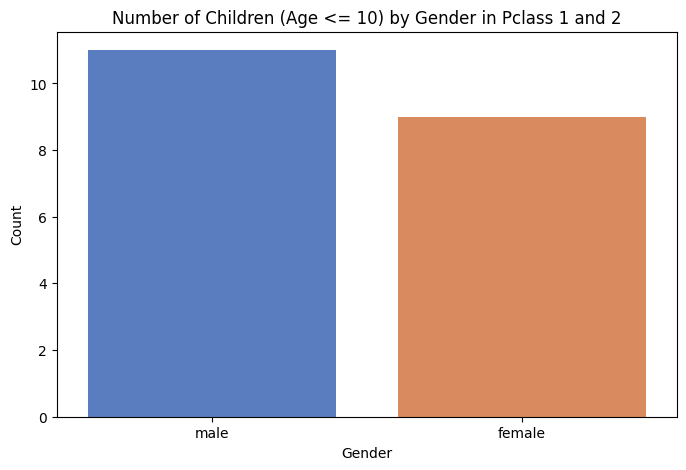

[actions]
[도구 호출]
Tool : python_repl_ast
query : {'query': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Filtering the DataFrame for passengers in Pclass 1 or 2 and Age 10 or below\nfiltered_df = df[(df['Pclass'].isin([1, 2])) & (df['Age'] <= 10)]\n\n# Counting the number of boys and girls\ngender_counts = filtered_df['Sex'].value_counts()\n\n# Visualization\nplt.figure(figsize=(8, 5))\nsns.barplot(x=gender_counts.index, y=gender_counts.values, palette='muted')\nplt.title('Number of Children (Age <= 10) by Gender in Pclass 1 and 2')\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.xticks(rotation=0)\nplt.show()"}
Log: 
Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Filtering the DataFrame for passengers in Pclass 1 or 2 and Age 10 or below\nfiltered_df = df[(df['Pclass'].isin([1, 2])) & (df['Age'] <= 10)]\n\n# Counting the number of boys and girls\ngender_counts = filtered_

In [80]:
for step in response:

    if 'actions' in step:
        print('==' * 50)
        print(f'[actions]')
        # print(step['actions'])
        print('[도구 호출]')
        print(f"Tool : {step['actions'][0].tool}")
        print(f"query : {step['actions'][0].tool_input}")
        print(f"Log: ", end='')
        print(f"{step['actions'][0].log}")
        # print(f"message log: {step['actions'][0].message_log}")
        print('==' * 50)

    elif 'steps' in step:
        print('\n')
        print('==' * 50)
        print(f'[steps]')
        # print(step['steps'])
        print(f"검색어: {step['steps'][0].action.tool_input}")
        # print(f"message log: {step['steps'][0].action.message_log}")
        print(f"[관찰 내용]")
        print(f"Observation:")
        print(f"{step['steps'][0].observation}")
        print('==' * 50)

    elif 'output' in step:
        print('==' * 50)
        # print(f"[output]: {step['output']}")
        print(f"[output]")
        print(f"step['messages']:")
        print(f"{step['messages'][0].content}")
        print('==' * 50)

In [81]:
def tool_callback(tool) -> None:
    print(f'===== 도구 호출 =====')
    print(f"사용된 도구 이름 : {tool[0].tool}")
    print(f"query : {tool[0].tool_input['query']}")
    print(f'===== 도구 호출 =====')

In [82]:
def obervation_callback(observation) -> None:
    print(f'\n===== 관찰 내용 =====')
    print(f"Observation: {observation[0].observation}")
    print(f'===== 관찰 내용 =====')

In [83]:
def result_callback(result: str) -> None:
    print(f'===== 최종 답변 =====')
    print(f"{result}")
    print(f'===== 최종 답변 =====')

In [84]:
response = agent.stream({'input': '몇 개의 행이 있어?'})

In [85]:
for step in response:
    if 'actions' in step:
        tool_callback(step['actions'])
    elif 'steps' in step:
        obervation_callback(step['steps'])
    elif 'output' in step:
        result_callback(step['messages'][0].content)    



> Entering new None chain...
===== 도구 호출 =====
사용된 도구 이름 : python_repl_ast
query : len(df)
===== 도구 호출 =====

Invoking: `python_repl_ast` with `{'query': 'len(df)'}`


891
===== 관찰 내용 =====
Observation: 891
===== 관찰 내용 =====
데이터프레임에는 총 891개의 행이 있습니다.

> Finished chain.
===== 최종 답변 =====
데이터프레임에는 총 891개의 행이 있습니다.
===== 최종 답변 =====


In [86]:
response = agent.stream({'input': '1,2 등급에 탑승한 10세 이하 어린 아이의 성별을 구하고 시각화 하세요'})



> Entering new None chain...


<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



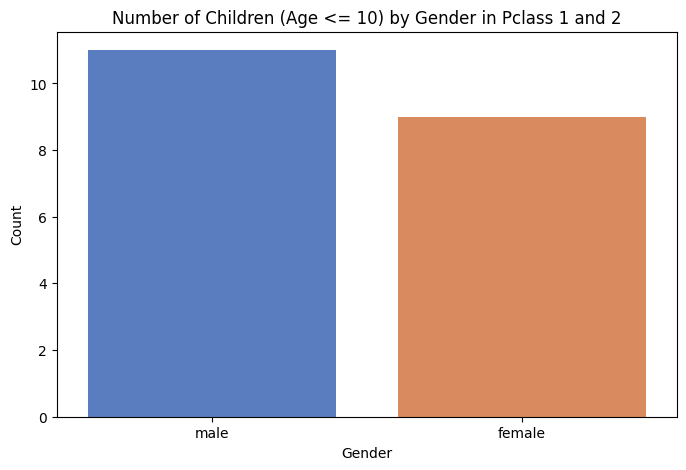

===== 도구 호출 =====
사용된 도구 이름 : python_repl_ast
query : import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering the DataFrame for passengers in Pclass 1 or 2 and Age 10 or below
filtered_df = df[(df['Pclass'].isin([1, 2])) & (df['Age'] <= 10)]

# Counting the number of boys and girls
gender_counts = filtered_df['Sex'].value_counts()

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='muted')
plt.title('Number of Children (Age <= 10) by Gender in Pclass 1 and 2')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
===== 도구 호출 =====

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Filtering the DataFrame for passengers in Pclass 1 or 2 and Age 10 or below\nfiltered_df = df[(df['Pclass'].isin([1, 2])) & (df['Age'] <= 10)]\n\n# Counting the number of boys and girls\ngender_counts = filtered_df['Sex'].va

In [87]:
for step in response:
    if 'actions' in step:
        tool_callback(step['actions'])
    elif 'steps' in step:
        obervation_callback(step['steps'])
    elif 'output' in step:
        result_callback(step['messages'][0].content)    